In [ ]:
# yahoo finance API for getting the stock data
#'''Docs of yfinance here: https://ranaroussi.github.io/yfinance/'''
# ====================Contributors====================
# In Alphabetical Order/ according to Roll Number
# 1. Akash Banik (M25MAC001)
# 2. Ali Asad Quasim (M25MAC002)
# 3. Anindita Pramanik (M25CSE006)
# ====================================================
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt



/tmp/ipython-input-4140073771.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y')
[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-11-09 to 2025-11-07
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1256 non-null   float64
 1   (High, AAPL)    1256 non-null   float64
 2   (Low, AAPL)     1256 non-null   float64
 3   (Open, AAPL)    1256 non-null   float64
 4   (Volume, AAPL)  1256 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

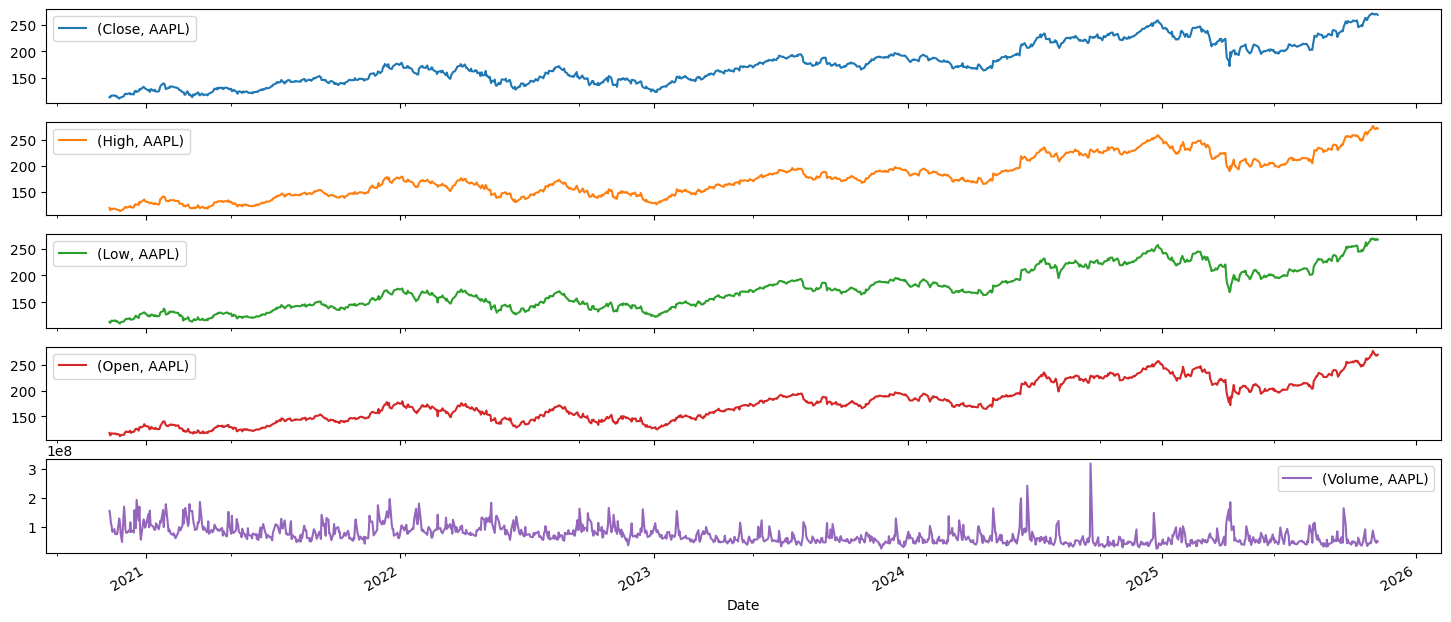

In [ ]:
ticker = "AAPL"
df = yf.download(ticker, period='5y')
df.info()
df = df.dropna()
df.plot(figsize=(18,8),subplots=True, sharex = True)

In [ ]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['STD_10'] = df['Close'].rolling(window=10).std()

# RSI Calculation for stocks using the formula
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean() #mean gain
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean() #mean loss
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df = df.dropna()


In [ ]:
window_size = 5
features, targets = [], []
for i in range(window_size, len(df) - 1):
    past_close = df['Close'].values[i - window_size:i].reshape(-1)  # Ensure 1D
    sma10 = float(df['SMA_10'].values[i])      # Ensure scalar
    sma20 = float(df['SMA_20'].values[i])      # Ensure scalar
    std10 = float(df['STD_10'].values[i])      # Ensure scalar
    rsi = float(df['RSI'].values[i])           # Ensure scalar
    feature_vector = np.concatenate((past_close, [sma10, sma20, std10, rsi]))
    features.append(feature_vector)
    targets.append(df['Close'].values[i + 1])


X = np.array(features)
y = np.array(targets)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()


In [ ]:
### DO NOT RUN THIS CELL EVERYTIME. Just run it the first time you run this notebook

# Use TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=3)

# New, refined hyperparameter grid (narrower C for RBF)
param_grid_rbf_refined = {
    'C': [i for i in range(10,101,10)],
    'epsilon': [0.05, 0.1, 0.5],
    'gamma': ['scale', 0.1,0.15, 1]
}

ksvr_rbf = SVR(kernel='rbf')

# Re-run Grid Search using TimeSeriesSplit
grid_search_rbf_ts = GridSearchCV(
    ksvr_rbf,
    param_grid_rbf_refined,
    cv=tscv,  # Use TimeSeriesSplit
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_rbf_ts.fit(X_train_scaled, y_train_scaled)
best_rbf_ts_model = grid_search_rbf_ts.best_estimator_

print("Optimal RBF model found using TimeSeriesSplit.", grid_search_rbf_ts.best_params_)

Optimal RBF model found using TimeSeriesSplit. {'C': 10, 'epsilon': 0.05, 'gamma': 0.1}


In [ ]:
### DO NOT RUN THIS CELL EVERYTIME. Just run it the first time you run this notebook
# Refined hyperparameter grid for sigmoid kernel
param_grid_sigmoid_refined = {
    'C': [i*0.1 for i in range(1, 10, 2)],         # Regularization parameter
    'epsilon': [0.1, 0.5],                 # SVR loss tube width
    'gamma': [ i*0.1 for i in range(10)],            # Kernel coefficient
    'coef0': [0, 1]                              # Independent term in kernel function
}

# Instantiate SVR with sigmoid kernel
ksvr_sigmoid = SVR(kernel='sigmoid')

# Grid Search with TimeSeriesSplit CV
grid_search_sigmoid_ts = GridSearchCV(
    ksvr_sigmoid,
    param_grid_sigmoid_refined,
    cv=tscv,                        # TimeSeriesSplit for time series data
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit grid search to training data
grid_search_sigmoid_ts.fit(X_train_scaled, y_train_scaled)
best_sigmoid_ts_model = grid_search_sigmoid_ts.best_estimator_

print("Optimal sigmoid SVR model found using TimeSeriesSplit.", grid_search_sigmoid_ts.best_params_)


Optimal sigmoid SVR model found using TimeSeriesSplit. {'C': 0.9, 'coef0': 0, 'epsilon': 0.1, 'gamma': 0.1}


In [ ]:
### DO NOT RUN THIS CELL EVERYTIME. Just run it the first time you run this notebook

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Refined hyperparameter grid for polynomial kernel
param_grid_poly_refined = {
    'C': [i for i in range(10, 101, 10)],         # Regularization parameter
    'epsilon': [0.05,0.1, 0.15, 0.2, 0.25, 0.5],                 # SVR loss tube width
    'degree': [2, 3],                         # Degree of the polynomial kernel
    'coef0': [0,1,2],                             # Independent term in kernel function
    'gamma': [ 0.1, 0.15, 1]             # Kernel coefficient
}

ksvr_poly = SVR(kernel='poly')

# Grid Search with TimeSeriesSplit CV
grid_search_poly_ts = GridSearchCV(
    ksvr_poly,
    param_grid_poly_refined,
    cv=tscv,                        # TimeSeriesSplit for time series data
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit grid search to training data
grid_search_poly_ts.fit(X_train_scaled, y_train_scaled)
best_poly_ts_model = grid_search_poly_ts.best_estimator_

print("Optimal polynomial SVR model found using TimeSeriesSplit.", grid_search_poly_ts.best_params_)


Optimal polynomial SVR model found using TimeSeriesSplit. {'C': 10, 'coef0': 2, 'degree': 2, 'epsilon': 0.05, 'gamma': 0.1}


In [ ]:
ksvr_rbf_best = SVR(kernel='rbf', **grid_search_rbf_ts.best_params_)
ksvr_rbf_best.fit(X_train_scaled, y_train_scaled)

ksvr_sigmoid_best = SVR(kernel="sigmoid", **grid_search_sigmoid_ts.best_params_)
ksvr_sigmoid_best.fit(X_train_scaled, y_train_scaled)

ksvr_poly_best = SVR(kernel="poly", **grid_search_poly_ts.best_params_)
ksvr_poly_best.fit(X_train_scaled, y_train_scaled)

svm_linear = SVR(kernel='linear', C=60, epsilon=0.1)
svm_linear.fit(X_train_scaled, y_train_scaled)


SVR(C=60, kernel='linear')

In [ ]:
y_pred_ksvr_rbf_scaled = ksvr_rbf_best.predict(X_test_scaled)
y_pred_ksvr_sigmoid_scaled = ksvr_sigmoid_best.predict(X_test_scaled)
y_pred_ksvr_poly_scaled = ksvr_poly_best.predict(X_test_scaled)

y_pred_svm_scaled = svm_linear.predict(X_test_scaled)

y_pred_ksvr_rbf = scaler_y.inverse_transform(y_pred_ksvr_rbf_scaled.reshape(-1,1)).ravel()
y_pred_ksvr_sigmoid = scaler_y.inverse_transform(y_pred_ksvr_sigmoid_scaled.reshape(-1,1)).ravel()
y_pred_ksvr_poly = scaler_y.inverse_transform(y_pred_ksvr_poly_scaled.reshape(-1,1)).ravel()

y_pred_svm = scaler_y.inverse_transform(y_pred_svm_scaled.reshape(-1,1)).ravel()


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame([mae, rmse, r2], columns=[model_name], index =["Mean Absolute Error", "Mean Square Error", "R2 Score"])
    print(f"{model_name} Performance:")
    print(f"  MAE = {mae:.3f}")
    print(f"  MSE = {rmse:.3f}")
    print(f"  R2 Score = {r2:.3f}\n")

pd.concat([evaluate_model(y_test, y_pred_svm, "SVM (Linear Kernel)"),
evaluate_model(y_test, y_pred_ksvr_rbf, "Tuned K-SVR (RBF Kernel)"),
evaluate_model(y_test, y_pred_ksvr_sigmoid, "Tuned K-SVR (Sigmoid Kernel)"),
evaluate_model(y_test, y_pred_ksvr_poly, "Tuned K-SVR (Polynomial Kernel)")], axis =1).head()



,SVM (Linear Kernel),Tuned K-SVR (RBF Kernel),Tuned K-SVR (Sigmoid Kernel),Tuned K-SVR (Polynomial Kernel)
Mean Absolute Error,6.659007,5.068920,344.563582,4.046402
Mean Square Error,8.745080,6.957027,409.884885,5.776863
R2 Score,0.827760,0.890993,-377.381011,0.924840


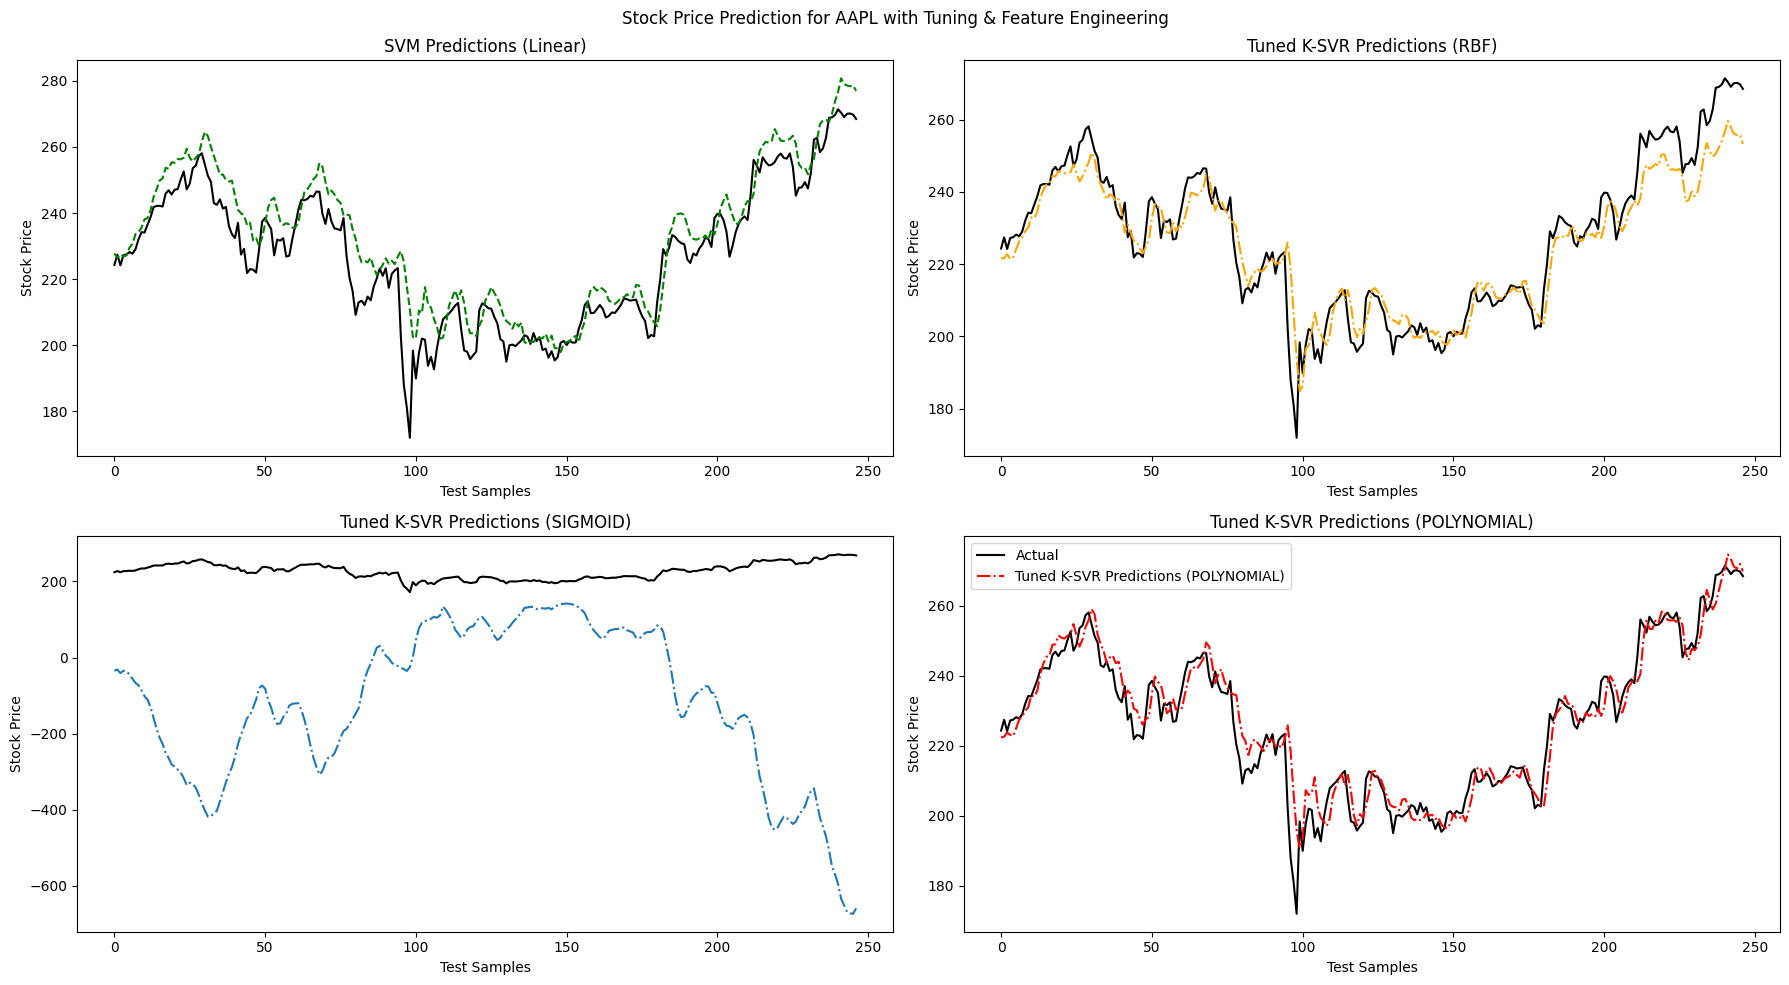

In [ ]:
fig, ax =plt.subplots(nrows=2, ncols=2, figsize=(18,10))
fig.suptitle(f'Stock Price Prediction for {ticker} with Tuning & Feature Engineering')
ax[0,0].plot(y_test, label='Actual', color='black')
ax[0,0].plot(y_pred_svm, '--', label='SVM Predictions (Linear)',color="green")
ax[0,0].set_title("SVM Predictions (Linear)")
ax[0,1].plot(y_test, label='Actual', color='black')
ax[0,1].plot(y_pred_ksvr_rbf, '-.', label='Tuned K-SVR Predictions (RBF)',color="orange")
ax[0,1].set_title("Tuned K-SVR Predictions (RBF)")
ax[1,0].plot(y_test, label='Actual', color='black')
ax[1,0].plot(y_pred_ksvr_sigmoid, '-.', label='Tuned K-SVR Predictions (SIGMOID)')
ax[1,0].set_title('Tuned K-SVR Predictions (SIGMOID)')
ax[1,1].plot(y_test, label='Actual', color='black')
ax[1,1].plot(y_pred_ksvr_poly, '-.', label='Tuned K-SVR Predictions (POLYNOMIAL)',color="red")
ax[1,1].set_title('Tuned K-SVR Predictions (POLYNOMIAL)')

ax[0,0].set_xlabel('Test Samples')
ax[0,0].set_ylabel('Stock Price')

ax[0,1].set_xlabel('Test Samples')
ax[0,1].set_ylabel('Stock Price')

ax[1,0].set_xlabel('Test Samples')
ax[1,0].set_ylabel('Stock Price')

ax[1,1].set_xlabel('Test Samples')
ax[1,1].set_ylabel('Stock Price')


plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pickle

# Save the trained model as a pickle string.

filename = "Polynomial Kernel Model.pkl"
with open(filename, 'wb') as file:
        pickle.dump(ksvr_poly_best, file)


filename = "RBF Kernel Model.pkl"
with open(filename, 'wb') as file:
        pickle.dump(ksvr_rbf_best, file)

saved_model = pickle.dumps(ksvr_sigmoid_best)
filename = "Sigmoid Kernel Model.pkl"
with open(filename, 'wb') as file:
        pickle.dump(ksvr_sigmoid_best, file)

saved_model = pickle.dumps(svm_linear)
filename = "Linear SVM Model.pkl"
with open(filename, 'wb') as file:
        pickle.dump(svm_linear, file)

In [ ]:
import pickle

Pkl_Filename = "Linear SVM Model.pkl"

with open(Pkl_Filename, 'rb') as file:
    loaded_model = pickle.load(file)


# Assuming 'X_test' contains our new data for prediction
predictions = loaded_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_ksvr_rbf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ksvr_rbf))
r2 = r2_score(y_test, y_pred_ksvr_rbf)

print("Performance:")
print(f"  MAE = {mae:.3f}")
print(f"  MSE {rmse:.3f}")
print(f"  R2 Score = {r2:.3f}\n")

Performance:
  MAE = 5.069
  RMSE = 6.957
  R2 Score = 0.891

